In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

## Hyperparameters and Constants

Here, we define wether to train the model or not and for how many epochs to train for.

If `TRAIN = False`, then the last trained model will be used for inference in the notebook if run end to end.

In [2]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 25

## Download and Prepare the Dataset

We will use the <a href="https://public.roboflow.com/object-detection/vehicles-openimages" target="_blank">Vehicles-OpenImages</a> dataset for training the custom YOLOv5 object detector.

Let's download the dataset.

In [3]:
if not os.path.exists('train'):
    !curl -L "https://public.roboflow.com/ds/xKLV14HbTF?key=aJzo7msVta" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    
    dirs = ['train', 'valid', 'test']

    for i, dir_name in enumerate(dirs):
        all_image_names = sorted(os.listdir(f"{dir_name}/images/"))
        for j, image_name in enumerate(all_image_names):
            if (j % 2) == 0:
                file_name = image_name.split('.jpg')[0]
                os.remove(f"{dir_name}/images/{image_name}")
                os.remove(f"{dir_name}/labels/{file_name}.txt")

The original data had two instances of each image and label file. The rest of the code in the above block deletes the duplicate image and it's corresponding text file containing the label.

The dataset is structured in the following manner:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

## Helper Functions to Download Files

The following function is for downloading any file in the notebook. In further sections of the notebook, we will use it for downloading the inference data.

In [4]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else: 
        print('File already present, skipping download...')

### The Dataset YAML File

The dataset YAML (`data.yaml`) file containing the path to the training and validation images and labels is already provided. This file will also contain the class names from the dataset.

The dataset contains 5 classes: **'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck'**.

The following block shows the contents of the `data.yaml` file.

```yaml
train: ../train/images
val: ../valid/images

nc: 5
names: ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
```

### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images. 

The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format.

In [5]:
class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [6]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [7]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [8]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

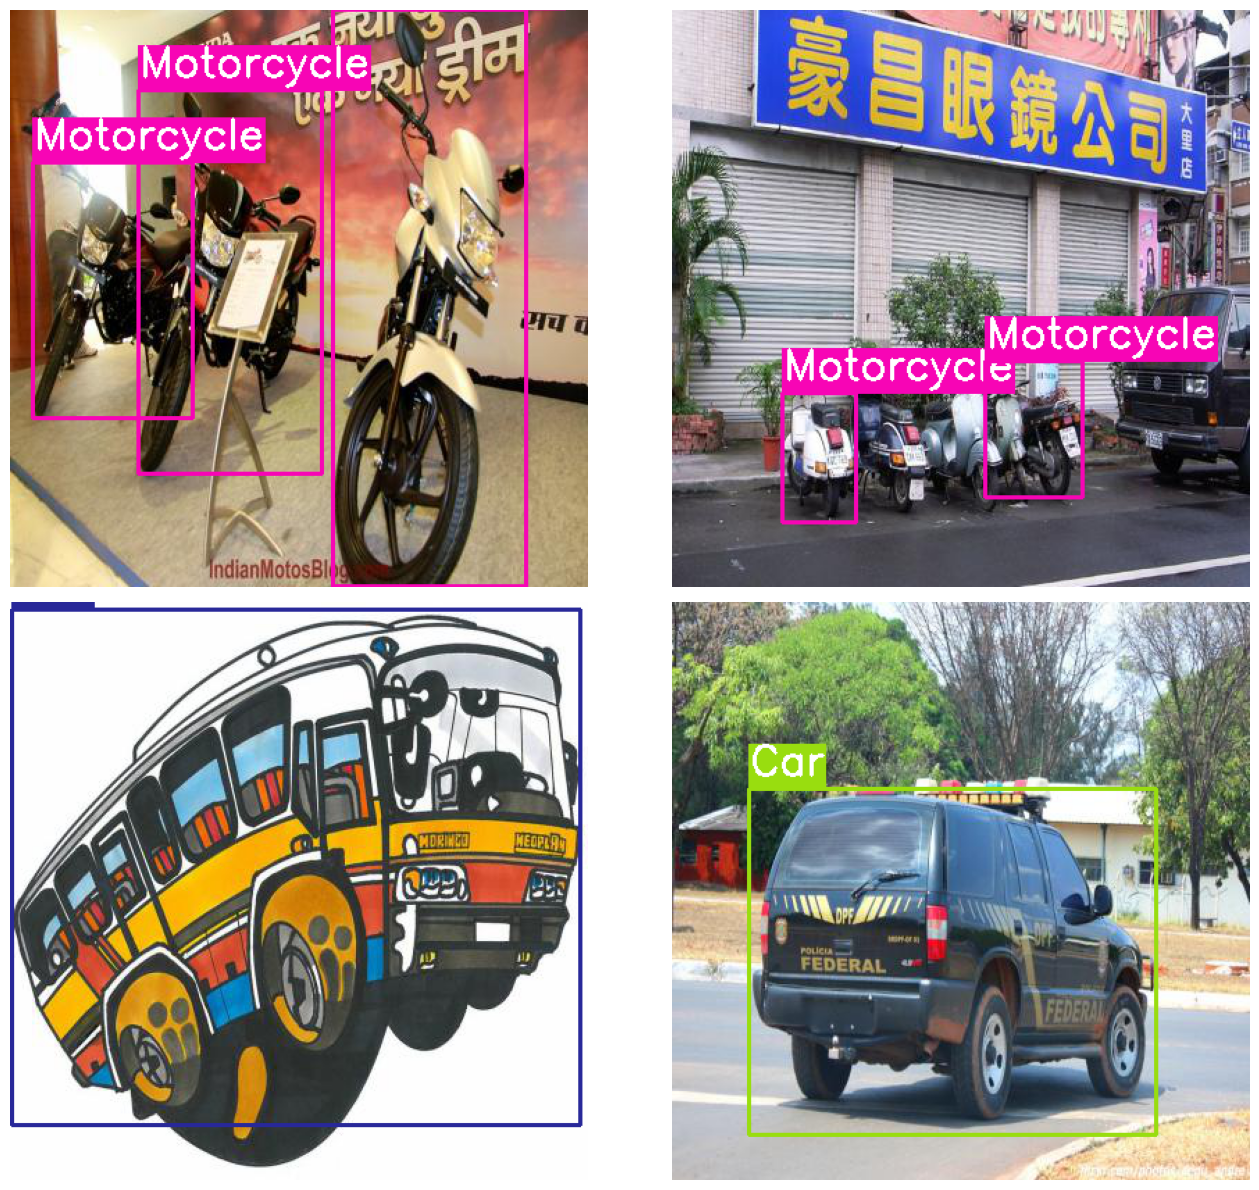

In [9]:
# Visualize a few training images.
plot(
    image_paths='train/images/*', 
    label_paths='train/labels/*',
    num_samples=4,
)

## Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [10]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

**Function to Monitor TensorBoard logs**.

In [11]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

## Clone YOLOV5 Repository

In [12]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...


In [13]:
%cd yolov5/
!pwd

c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yolo\yolov5


'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
!pip install -r requirements.txt

     ------------------------------------- 184.3/184.3 kB 11.6 MB/s eta 0:00:00
     --------------------------------------- 38.2/38.2 MB 25.2 MB/s eta 0:00:00
     --------------------------------------- 42.5/42.5 MB 28.5 MB/s eta 0:00:00
     ------------------------------------- 162.5/162.5 MB 13.6 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 34.9 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB ? eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 27.6 MB/s eta 0:00:00
     --------------------------------------- 10.9/10.9 MB 32.8 MB/s eta 0:00:00
     ---------------------------------------- 293.3/293.3 kB ? eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB ? eta 0:00:00
  Using cached Markdown-3.4.1-py3-none-any.whl (93 kB)
     ------------------------------------- 420.6/420.6 kB 25.7 MB/s eta 0:00:00
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
     -----------

## Training using YOLOV5

The next step is to train the neural network model.

### Train a Small (yolov5s) Model

Training all the layers of the small model.

In [15]:
monitor_tensorboard()

In [16]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 0
results_1


train: weights=yolov5s.pt, cfg=, data=../data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=results_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
fatal: cannot change to 'C:\Users\charl\VSCode': No such file or directory
YOLOv5  2023-2-23 Python-3.9.16 torch-1.13.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_

## Check Out the Validation Predictions and Inference

In this section, we will check out the predictions of the validation images saved during training. Along with that, we will also check out inference of images and videos.

### Visualization and Inference Utilities

We will visualize the validation prediction images that are saved during training. The following is the function for that.

In [17]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on images and videos.

In [18]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

We may also need to visualize images in any of the directories. The following function accepts a directory path and plots all the images in them. 

In [19]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

**Visualize validation prediction images.**

In [20]:
show_valid_results(RES_DIR)

'ls' is not recognized as an internal or external command,
operable program or batch file.


[]


### Inference
In this section, we will carry out inference on unseen images and videos from the internet. 

The images for inference are in the `inference_images` directory.

The videos for inference are in the `inference_videos` directory.

### Download the Images and Videos
Let's download the images and videos that we will carry inference upon.

In [21]:
download_file('https://learnopencv.s3.us-west-2.amazonaws.com/yolov5_inference_data.zip',
              'inference_data.zip')
if not os.path.exists('inference_images'):
    !unzip -q "inference_data.zip"
else:
    print('Dataset already present')

'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Inference on Images

**To carry out inference on images, we just need to provide the directory path where all the images are stored, and inference will happen on all images automatically.**

In [22]:
# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images')

Current number of inference detection directories: 0
inference_1


detect: weights=['runs/train/results_1/weights/best.pt'], source=inference_images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=inference_1, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'C:\Users\charl\VSCode': No such file or directory
YOLOv5  2023-2-23 Python-3.9.16 torch-1.13.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Traceback (most recent call last):
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yolo\yolov5\detect.py", line 261, in <module>
    main(opt)
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yolo

In [23]:
visualize(IMAGE_INFER_DIR)

[]


### Inference on Videos

In [24]:
inference(RES_DIR, 'inference_videos')

Current number of inference detection directories: 1
inference_2


detect: weights=['runs/train/results_1/weights/best.pt'], source=inference_videos, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=inference_2, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'C:\Users\charl\VSCode': No such file or directory
YOLOv5  2023-2-23 Python-3.9.16 torch-1.13.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Traceback (most recent call last):
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yolo\yolov5\detect.py", line 261, in <module>
    main(opt)
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yolo

'inference_2'

## Training and Inference using  Medium Model

In [25]:
monitor_tensorboard()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 31896), started 0:13:20 ago. (Use '!kill 31896' to kill it.)

In [26]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5m.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 1
results_2


train: weights=yolov5m.pt, cfg=, data=../data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=results_2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
fatal: cannot change to 'C:\Users\charl\VSCode': No such file or directory
YOLOv5  2023-2-23 Python-3.9.16 torch-1.13.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_

In [27]:
# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images')

Current number of inference detection directories: 2
inference_3


detect: weights=['runs/train/results_2/weights/best.pt'], source=inference_images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=inference_3, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'C:\Users\charl\VSCode': No such file or directory
YOLOv5  2023-2-23 Python-3.9.16 torch-1.13.1+cpu CPU

Fusing layers... 
Model summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
Traceback (most recent call last):
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yolo\yolov5\detect.py", line 261, in <module>
    main(opt)
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yol

In [28]:
visualize(IMAGE_INFER_DIR)

[]


In [29]:
inference(RES_DIR, 'inference_videos')

Current number of inference detection directories: 3
inference_4


detect: weights=['runs/train/results_2/weights/best.pt'], source=inference_videos, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=inference_4, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'C:\Users\charl\VSCode': No such file or directory
YOLOv5  2023-2-23 Python-3.9.16 torch-1.13.1+cpu CPU

Fusing layers... 
Model summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
Traceback (most recent call last):
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yolo\yolov5\detect.py", line 261, in <module>
    main(opt)
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yol

'inference_4'

## Freezing Layers and Training the Medium Model

The Medium model (yolov5m) contains 25 blocks layers in total more than 20 million parameters. We need not train all the layers. Let's freeze a few layers and train again. This will result in faster iteration per epoch. Here, we freeze the first 15 blocks.

In [30]:
monitor_tensorboard()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 31896), started 0:38:50 ago. (Use '!kill 31896' to kill it.)

In [31]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5m.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} \
    --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14

Current number of result directories: 2
results_3


train: weights=yolov5m.pt, cfg=, data=../data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=results_3, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
fatal: cannot change to 'C:\Users\charl\VSCode': No such file or directory
YOLOv5  2023-2-23 Python-3.9.16 torch-1.13.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, ob

In [32]:
# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images')

Current number of inference detection directories: 4
inference_5


detect: weights=['runs/train/results_3/weights/best.pt'], source=inference_images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=inference_5, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'C:\Users\charl\VSCode': No such file or directory
YOLOv5  2023-2-23 Python-3.9.16 torch-1.13.1+cpu CPU

Fusing layers... 
Model summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
Traceback (most recent call last):
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yolo\yolov5\detect.py", line 261, in <module>
    main(opt)
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yol

In [33]:
visualize(IMAGE_INFER_DIR)

[]


In [34]:
inference(RES_DIR, 'inference_videos')

Current number of inference detection directories: 5
inference_6


detect: weights=['runs/train/results_3/weights/best.pt'], source=inference_videos, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=inference_6, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'C:\Users\charl\VSCode': No such file or directory
YOLOv5  2023-2-23 Python-3.9.16 torch-1.13.1+cpu CPU

Fusing layers... 
Model summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
Traceback (most recent call last):
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yolo\yolov5\detect.py", line 261, in <module>
    main(opt)
  File "c:\Users\charl\VSCode Projects\CMSC330\project0\project-1b-charlielu04\Innovation-Factory\yol

'inference_6'